<a href="https://colab.research.google.com/github/tshjustin/A1_cartpole-v1/blob/main/SC3000_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !pip install gym[classic_control]
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [2]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space) # Possible actions in the env

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space) # all POSSIBLE observation space [pos,velocity,angle,velocity] - We would have inf positions

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [ ]:
observation = env.reset()
print("Initial observations:", observation) # initial values of the state

Initial observations: [-0.04695734 -0.03280946  0.04606579  0.04499507]


In [ ]:
observation, reward, done, info = env.step(0) # executes an action in the env
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done) # Done depends when one of the 3 conditions of termiantion are met

New observations after choosing action 0: [-0.04761353 -0.22856067  0.04696569  0.35184893]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
env.observation_space.shape[0] # returns the number of features of the environemnt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4

## Task 1: Development of an RL agent

### DQN:

1. Network model: Input would have 4 neurons - Each representing a state feature, with a final output of 2 neurons - Corresponding to one action each


2. Passing a batch of experience inside the model in the form of: [Batch Number, n_observations]. [[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], ...].


3. The output we expect is the batch dimension of input, but the values inside represent:
[[Q-value(action1), Q-value(action2)], [Q-value(action1), Q-value(action2)]]  


4.





In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import random
from collections import deque

class Memory(object):
    def __init__(self, maxlen):
        self.memory = deque(maxlen=maxlen) # sets the maximum number of experiences - Oldeset entries removed while newest are placed at the end of the queue

    def store(self, experience):
        self.memory.append(experience) # adds an experience <state, action, reward, new state, done>

    def sample(self, n_samples):
        return zip(*random.sample(self.memory, n_samples)) # takes a random sample & transpose from [(state1, action1, reward1, next_state1, done1), (state2, action2, reward2, next_state2, done2) ...] -> (state1, state2), (action1, action2), (reward1, reward2), (next_state1, next_state2), (done1, done2)

    def __len__(self):
        return len(self.memory) # current size of memory buffer


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_layers):
        super(DQN, self).__init__()

        self.feature_extractor = env.observation_space.shape[0] # retrieve the number of features - This number of features corresponds to the number of input neurons of the model

        # Neural network
        self.net = nn.Sequential(
            nn.Linear(self.feature_extractor, n_layers),
            nn.ReLU(),
            nn.Linear(n_layers, n_layers),
            nn.ReLU(),
            nn.Linear(n_layers, n_actions.n),
        )

    def forward(self, obs):
        '''
        params:
        obs: observation / state of environemnt that is to be evaluated

        return:
        set of q values for the input state.
        '''
        return self.net(obs)

def wrap_input(arr, device, dtype=torch.float, reshape=False):
    '''
    Takes the array and converts it into a tensor & typecasted
    '''
    output = torch.from_numpy(np.array(arr)).type(dtype).to(device)
    if reshape: # in the case for neural networks that require 2d inputs
        output = output.reshape(-1, 1)

    return output

def epsilon_greedy(start, end, n_steps, current_iteration):
    '''
    For early exploration and exploitation later on

    Decays as iteration approaches the number of steps we defined
    '''
    return max(start - (start - end) * (current_iteration / n_steps), end)

In [28]:
def main() -> int:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(env.observation_space, env.action_space, 128).to(device)

    optimizer = optim.Adam(model.parameters(), lr=.0001)
    loss_fn = nn.MSELoss()
    memory = Memory(15_000)

    episode_count = 0

    obs = env.reset()
    total_reward = 0

    for iteration in range(100_000):  # each iteration means an experience, which is contained within an episode


        # generate experiences first using epsilon greedy

        if np.random.random() <= epsilon_greedy(1.0, .01, 15_000, iteration): # choose some random number in [0,1). If lower than epsilon, then take some ranom action
            action = env.action_space.sample() # choose either 0 / 1

        else: # takes the action that gives the max returns
            state = wrap_input(obs, device).unsqueeze(0) # obtain the current state of the iteration and converts it into a tensor - unsqueeze(0) adds another dimenson at index=0 - [a,b,c,d] => [[a,b,c,d]], since for single state, the batch size = 1 and we need the extra dimention to indicate that the size = 1.
            action  = model(state).argmax().item() # feeds state inside the model, and obtain the index of the q-value that is the max in the form of a tensor, .item() to convert it to an index which is our action.

        next_state, reward, done, info = env.step(action) # observations after take the action
        total_reward += reward

        if done: # check for termination
            next_state = np.zeros(env.observation_space.shape) # observation state all 0s if termination - prevents None Error

        memory.store([obs, action, reward, int(done), next_state]) # stores the observation of the future state - Becomes experience

        obs = next_state

        if done:
            print("total_reward = ", total_reward)
            obs = env.reset()
            total_reward = 0
            episode_count += 1


        # Train if enough experiences
        if len(memory) > 500:
            model.train()
            states, actions, rewards, dones, next_states = memory.sample(128) # takes a batch of 128 experiences & seperate all the states, actions ...

            # prepare inputs
            states = wrap_input(states, device)
            actions = wrap_input(actions, device, torch.int64, reshape=True)
            next_states = wrap_input(next_states, device)
            rewards = wrap_input(rewards, device, reshape=True)
            dones = wrap_input(dones, device, reshape=True)

            qs = model(states)   # qs is a tensor of q values = [[x1,y1], [x2,y2]....] - With each tensor being Q value for taking action 0/1 in each state

            qs = torch.gather(qs, dim=1, index=actions) # we dont want all the Q values, rather the Q values that are associated with the values that we have already taken in our experience
            # Eventually, we get qs = [[q1],[q2]..] => predicted Q value for the actual action that we have taken

            # Compute target q-values using future state Q value
            with torch.no_grad():
                next_qs, _ = model(next_states).max(dim=1) # find Q of the fuuture state

                next_qs = next_qs.reshape(-1, 1) # Reshape such that [0.5, 0.7, 0.6, 0.4] => [[0.5], [0.7], [0.6], [0.4]] => (-1 = adjust the number of rows as needed based on the number of inputs, 1 = 1 column)

            target_qs = rewards + .9 * (1 - dones) * next_qs # Q = Q(s`,a`) r+γmax(s`,a`)

            # Compute loss
            loss = loss_fn(qs, target_qs)
            optimizer.zero_grad()
            loss.backward()

            # Backprop
            optimizer.step()

    print("Episode Count",episode_count)
    torch.save(model.state_dict(), 'checkpoint.pth')

main()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


total_reward =  21.0
total_reward =  27.0
total_reward =  26.0
total_reward =  32.0
total_reward =  10.0
total_reward =  23.0
total_reward =  13.0
total_reward =  12.0
total_reward =  9.0
total_reward =  50.0
total_reward =  24.0
total_reward =  19.0
total_reward =  24.0
total_reward =  11.0
total_reward =  14.0
total_reward =  30.0
total_reward =  38.0
total_reward =  20.0
total_reward =  22.0
total_reward =  12.0
total_reward =  13.0
total_reward =  11.0
total_reward =  12.0
total_reward =  64.0
total_reward =  19.0
total_reward =  10.0
total_reward =  21.0
total_reward =  22.0
total_reward =  42.0
total_reward =  13.0
total_reward =  20.0
total_reward =  12.0
total_reward =  13.0
total_reward =  25.0
total_reward =  11.0
total_reward =  34.0
total_reward =  30.0
total_reward =  13.0
total_reward =  15.0
total_reward =  12.0
total_reward =  19.0
total_reward =  13.0
total_reward =  17.0
total_reward =  19.0
total_reward =  29.0
total_reward =  23.0
total_reward =  48.0
total_reward =

In [29]:
def main2() -> int:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(env.observation_space, env.action_space, 128).to(device)
    target = DQN(env.observation_space, env.action_space, 128).to(device)
    TARGET_UPDATE_FREQ = 1000

    optimizer = optim.Adam(model.parameters(), lr=.0001)
    loss_fn = nn.MSELoss()
    memory = Memory(20_000)

    episode_count = 0

    obs = env.reset()
    total_reward = 0

    for iteration in range(100_000):


        # generate experiences first using epsilon greedy

        if np.random.random() <= epsilon_greedy(1.0, .01, 15_000, iteration): # choose some random number in [0,1). If lower than epsilon, then take some ranom action
            action = env.action_space.sample() # choose either 0 / 1

        else: # takes the action that gives the max returns
            state = wrap_input(obs, device).unsqueeze(0) # obtain the current state of the iteration and converts it into a tensor - unsqueeze(0) adds another dimenson at index=0 - [a,b,c,d] => [[a,b,c,d]], since for single state, the batch size = 1 and we need the extra dimention to indicate that the size = 1.
            action  = model(state).argmax().item() # feeds state inside the model, and obtain the index of the q-value that is the max in the form of a tensor, .item() to convert it to an index which is our action.

        next_state, reward, done, info = env.step(action) # observations after take the action
        total_reward += reward

        if done: # check for termination
            next_state = np.zeros(env.observation_space.shape) # observation state all 0s if termination - prevents None Error

        memory.store([obs, action, reward, int(done), next_state]) # stores the observation of the future state - Becomes experience

        obs = next_state

        if done:
            print("total_reward = ", total_reward)
            obs = env.reset()
            total_reward = 0
            episode_count += 1


        # Train if enough experiences
        if len(memory) > 500:
            model.train()
            states, actions, rewards, dones, next_states = memory.sample(128) # takes a batch of 128 experiences & seperate all the states, actions ...

            # prepare inputs
            states = wrap_input(states, device)
            actions = wrap_input(actions, device, torch.int64, reshape=True)
            next_states = wrap_input(next_states, device)
            rewards = wrap_input(rewards, device, reshape=True)
            dones = wrap_input(dones, device, reshape=True)

            qs = model(states)   # qs is a tensor of q values = [[x1,y1], [x2,y2]....] - With each tensor being Q value for taking action 0/1 in each state

            qs = torch.gather(qs, dim=1, index=actions) # we dont want all the Q values, rather the Q values that are associated with the values that we have already taken in our experience
            # Eventually, we get qs = [[q1],[q2]..] => predicted Q value for the actual action that we have taken

            # Compute target q-values using future state Q value
            with torch.no_grad():
                next_qs, _ = target(next_states).max(dim=1) # find Q of the fuuture state  - Using the target network

                next_qs = next_qs.reshape(-1, 1) # Reshape such that [0.5, 0.7, 0.6, 0.4] => [[0.5], [0.7], [0.6], [0.4]] => (-1 = adjust the number of rows as needed based on the number of inputs, 1 = 1 column)

            target_qs = rewards + .9 * (1 - dones) * next_qs # Q = Q(s`,a`) r+γmax(s`,a`)

            if iteration % TARGET_UPDATE_FREQ == 0: # soft update
              target.load_state_dict(model.state_dict())
              print("target net updated")

            # Compute loss
            loss = loss_fn(qs, target_qs)
            optimizer.zero_grad()
            loss.backward()

            # Backprop
            optimizer.step()
    print("Episode Count",episode_count)
    torch.save(model.state_dict(), 'checkpoint2.pth')


In [30]:
main2()

total_reward =  21.0
total_reward =  23.0
total_reward =  10.0
total_reward =  24.0
total_reward =  13.0
total_reward =  23.0
total_reward =  16.0
total_reward =  32.0
total_reward =  20.0
total_reward =  15.0
total_reward =  24.0
total_reward =  16.0
total_reward =  16.0
total_reward =  11.0
total_reward =  25.0
total_reward =  13.0
total_reward =  27.0
total_reward =  14.0
total_reward =  14.0
total_reward =  14.0
total_reward =  29.0
total_reward =  20.0
total_reward =  25.0
total_reward =  17.0
total_reward =  38.0
total_reward =  19.0
total_reward =  16.0
total_reward =  25.0
total_reward =  22.0
total_reward =  33.0
total_reward =  14.0
total_reward =  38.0
total_reward =  14.0
total_reward =  23.0
total_reward =  22.0
total_reward =  10.0
total_reward =  28.0
total_reward =  39.0
total_reward =  19.0
total_reward =  34.0
total_reward =  28.0
total_reward =  36.0
total_reward =  57.0
total_reward =  21.0
target net updated
total_reward =  26.0
total_reward =  11.0
total_reward = 

KeyboardInterrupt: 

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

Print the average reward over the 100 episodes.

In [31]:
def test_model():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(env.observation_space, env.action_space, 128).to(device)

    state_dict = torch.load('checkpoint.pth')
    model.load_state_dict(state_dict)
    model.eval()

    total_rewards = []

    for episode in range(100):
        obs = env.reset()
        episode_reward = 0

        while True: # unil the episodes reaches termination
            state = wrap_input(obs, device).unsqueeze(0)
            action = model(state).argmax().item()  # Select action based on model's prediction
            obs, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Total Reward = {episode_reward}")

    avg_reward = sum(total_rewards) / len(total_rewards)
    print(f"Average Reward over 100 episodes: {avg_reward}")
    return total_rewards

total_rewards = test_model()


Episode 1: Total Reward = 369.0
Episode 2: Total Reward = 273.0
Episode 3: Total Reward = 238.0
Episode 4: Total Reward = 263.0
Episode 5: Total Reward = 244.0
Episode 6: Total Reward = 284.0
Episode 7: Total Reward = 335.0
Episode 8: Total Reward = 338.0
Episode 9: Total Reward = 250.0
Episode 10: Total Reward = 287.0
Episode 11: Total Reward = 358.0
Episode 12: Total Reward = 346.0
Episode 13: Total Reward = 254.0
Episode 14: Total Reward = 294.0
Episode 15: Total Reward = 325.0
Episode 16: Total Reward = 269.0
Episode 17: Total Reward = 293.0
Episode 18: Total Reward = 314.0
Episode 19: Total Reward = 276.0
Episode 20: Total Reward = 247.0
Episode 21: Total Reward = 293.0
Episode 22: Total Reward = 275.0
Episode 23: Total Reward = 226.0
Episode 24: Total Reward = 213.0
Episode 25: Total Reward = 391.0
Episode 26: Total Reward = 221.0
Episode 27: Total Reward = 308.0
Episode 28: Total Reward = 396.0
Episode 29: Total Reward = 268.0
Episode 30: Total Reward = 250.0
Episode 31: Total R

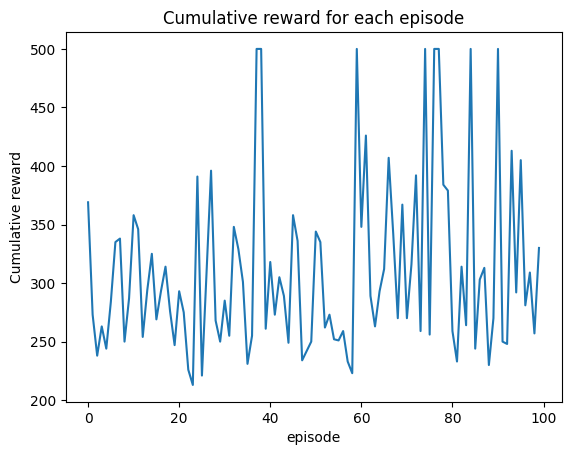

In [32]:
plt.plot(total_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [33]:
print("Average cumulative reward:", sum(total_rewards) / len(total_rewards))
print("Is my agent good enough?", sum(total_rewards) / len(total_rewards) > 195)

Average cumulative reward: 310.37
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = rand_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()